파이토치 버전: 2.0.1+cu118
사용하는 디바이스: cuda
[*********************100%***********************]  1 of 1 completed
Epoch [10/10000], Loss: 0.0002567
Epoch [20/10000], Loss: 0.0001356
Epoch [30/10000], Loss: 0.0001150
Epoch [40/10000], Loss: 0.0000805
Epoch [50/10000], Loss: 0.0000663
Epoch [60/10000], Loss: 0.0000576
Epoch [70/10000], Loss: 0.0000728
Epoch [80/10000], Loss: 0.0000490
Epoch [90/10000], Loss: 0.0000498
Epoch [100/10000], Loss: 0.0000383
Epoch [110/10000], Loss: 0.0000402
Epoch [120/10000], Loss: 0.0000414
Epoch [130/10000], Loss: 0.0000337
Epoch [140/10000], Loss: 0.0000353
Epoch [150/10000], Loss: 0.0000343
Epoch [160/10000], Loss: 0.0000348
Epoch [170/10000], Loss: 0.0000222
Epoch [180/10000], Loss: 0.0000302
Epoch [190/10000], Loss: 0.0000329
Epoch [200/10000], Loss: 0.0000203
Epoch [210/10000], Loss: 0.0000282
Epoch [220/10000], Loss: 0.0000172
Epoch [230/10000], Loss: 0.0000195
Epoch [240/10000], Loss: 0.0000161
Epoch [250/10000], Loss: 0.0000149
Epoch [260/10000], Loss: 0.0

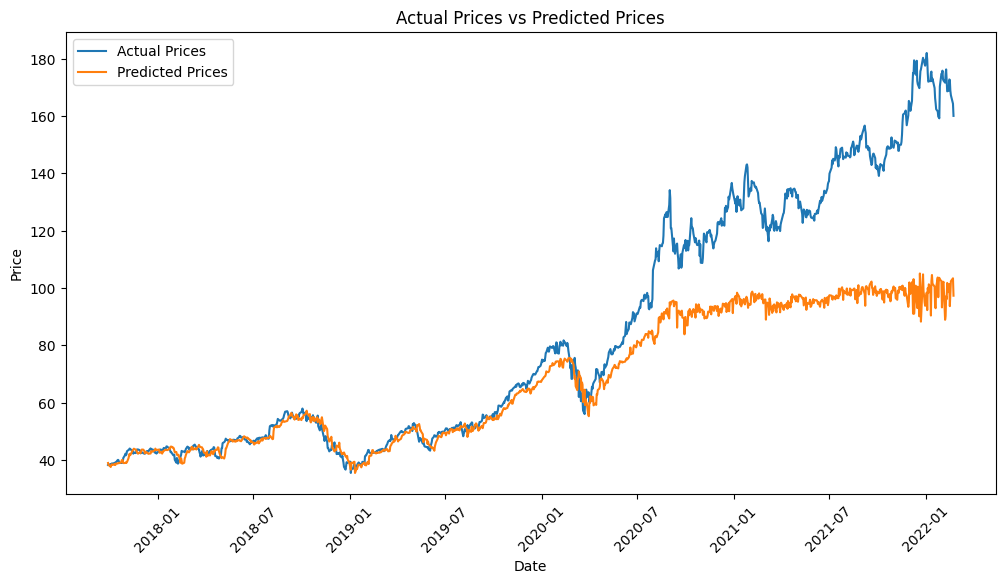

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 파이토치 버전과 디바이스(CPU 또는 CUDA) 설정
print("파이토치 버전:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("사용하는 디바이스:", device)

# 하이퍼파라미터 설정
num_epochs = 10000
learning_rate = 0.001
input_size = 5
hidden_size = 64
num_layers = 2
num_classes = 1
batch_size = 64

# 주식 데이터 가져오기
start_date = '2000-01-01'
end_date = '2022-02-24'
data = yf.download('AAPL', start=start_date, end=end_date)

# 입력 데이터와 출력 데이터 준비
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaler_close = MinMaxScaler()
scaled_close = scaler_close.fit_transform(data['Close'].values.reshape(-1, 1))

# 학습 데이터와 테스트 데이터 분할
train_size = int(len(scaled_features) * 0.8)
train_data = scaled_features[:train_size]
train_target = scaled_close[:train_size]
test_data = scaled_features[train_size:]
test_target = scaled_close[train_size:]

# 데이터를 텐서로 변환하고 모델에 적합한 형태로 재구성
class StockDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.data[index]
        x = x.unsqueeze(0)  # 2D를 3D로 변환
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

train_dataset = StockDataset(train_data, train_target)
test_dataset = StockDataset(test_data, test_target)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Transformer 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=4,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
        )
        self.decoder = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_size)
        x = self.transformer(x, x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size)
        x = self.decoder(x[:, -1, :])  # (batch_size, num_classes)
        return x

model = TransformerModel(input_size, hidden_size, num_layers, num_classes).to(device)

# 손실 함수와 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 시작
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_data, batch_target in train_loader:
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        # 순방향 전파
        output = model(batch_data)
        loss = criterion(output, batch_target)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.7f}")

# 모델을 평가 모드로 전환
model.eval()

# 테스트 데이터 예측
predictions = []
with torch.no_grad():
    for batch_data, batch_target in test_loader:
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        # 순방향 전파
        output = model(batch_data)
        predictions.extend(output.tolist())

# 예측 결과를 실제 값의 스케일로 변환
predicted_prices = scaler_close.inverse_transform(np.array(predictions).reshape(-1, 1))

# 실제 데이터와 예측한 데이터 시각화
dates = data.index[train_size + input_size + 1:]  # 예측에 사용된 기간 이후의 날짜
actual_prices = data['Close'].values[train_size + input_size + 1:]  # 실제 종가 데이터

# 예측한 데이터의 크기를 실제 데이터와 동일하게 조정
predicted_prices = predicted_prices[:len(actual_prices)]

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual Prices')
plt.plot(dates, predicted_prices, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Prices vs Predicted Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()
